# First steps in Jags

We will now dive straight in at the deep end, and start using Jags. We will develop progessively more complex examples, starting out with estimating rates of a Binomial distribution, and then also the mean of a Gaussian distribution.

This may seem hard at first, especially if you are not used to 'coding', but it certainly helps us to understand what we are doing.

Later, we will use an R package, "BayesFactor", which will do all the heavy lifting for us, but with this background, it will be much easier to comprehend what is actually being done for us.

We will start with basic parameter estimation.

The following examples all borrow heavily from Lee & Wagenmakers (2014). 

## General procedure for calling Jags from R

First, we need to load an R package that will allow us to call Jags from within R. There are 3 packages, which all do more or less the same thing; the easiest to use is probably 'R2jags'.

In [2]:
library(R2jags)

Loading required package: rjags
Loading required package: coda
Loading required package: lattice
Linked to JAGS 3.4.0
Loaded modules: basemod,bugs

Attaching package: ‘R2jags’

The following object is masked from ‘package:coda’:

    traceplot



We will continue with our introductory example: We are trying to infer a person's ability in a test consisting of a number (n) of questions, and we observe k correct answers.

We know that the number of correct answers is a binomial random variable. In fact, k is the sum of n Bernoulli trials, with each response being either correct (1) or incorrect (0). We also need a prior guess for the ability, or rate parameter, $\theta$. We will start with our uniform prior.

Therefore:

$$ k \sim Binomial(\theta, n)$$
and
$$\theta \sim Beta(1, 1)$$
or, equivalently
$$ \theta \sim Uniform(0, 1)$$


Now, in order to use Jags we basically follow this recipe:

1) We specify our model (as above) in a text file, using the Jags model description syntax.

2) We specify the observed data

3) We can specify initial values for the MCMC sampling process. This is actually required, but is recommended for more complex examples.

4) We call Jags, giving it the model and the data, (aind initial values) as arguments.

5) We make sure that sampling was 'successful'.

6) We inspect the posterior estimates.

### Model specification

Save the following text in a text file. Name the file "rate1.bug". This is the Jags model: 

``` R
model{
    # likelihood
    k ~ dbinom(theta, n)
    
    # prior
    theta ~ dbeta(1, 1)
}
```



Note that the model description is enclosed in 

``` R
model{}
```

The `~` means "is distributed as...".

In the model, `k` is the number of correct answers, and is the observed data. The same applies to `n`, which is the number of questions. The line 
``` R
k ~ dbinom(theta, n)
```
is therefore our likelihood function. The prior is specified by 
``` R 
theta ~ dbeta(1, 1)
```


In [3]:
modelstr <- "
model{
    # likelihood
    k ~ dbinom(theta, n)
    
    # prior
    theta ~ dbeta(1, 1)
}"

### Data

Next, we need to tell Jags where to find the data. We provide all observed data, in this case `k` and `n`, in a list:

In [4]:
jagsdata <- list(k = 9, n = 10)

### Initial values

It is also good practise to provide initial random values for all unknown parameters, for the sampling process. In this case, the unknown parameter is `theta`, and we know that this parameter must lie in the interval $[0,1]$, so we provide a unifor random number:

In [5]:
inits <- function() {
    list(theta = rbeta(1, 1, 1))
}

This is actually a function, which generates a random value for `theta` each time it is called. We do this so that Jags can run multiple Markov chains, using a different random value for each one.

### Specify which parameters we want to monitor

We need to tell Jags which parameters we are interested in. In this case, we want posterior samples for `theta`:

In [6]:
parameters = "theta"

If we have more than one parameter we would like to monitor, we can put them into a vector, e.g. 
``` R
parameters = c("param1", "param2", "param3")
```

### Call Jags

Now we are ready to call Jags. We use the function `jags()`. In order to discover what arguments the function takes, take a few minutes to play around with it at the R command line.

In [9]:
fit <- jags(data = jagsdata, model.file = textConnection(modelstr), 
             inits = inits, n.chains = 4,
             n.iter = 1000, n.thin = 1,n.burnin = 1,
             parameters.to.save = parameters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 4

Initializing model



In [10]:
print(fit)

Inference for Bugs model at "6", fit using jags,
 4 chains, each with 1000 iterations (first 1 discarded)
 n.sims = 3996 iterations saved
         mu.vect sd.vect  2.5%   25%   50%   75% 97.5%  Rhat n.eff
theta      0.833   0.105 0.581 0.769 0.854 0.911 0.976 1.001  4000
deviance   2.881   1.397 1.897 1.986 2.320 3.220 6.962 1.001  4000

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 1.0 and DIC = 3.9
DIC is an estimate of expected predictive error (lower deviance is better).


### Check for convergence

In order to check whether everything went according to plan, we can look at the value of $\hat{R}$, or potential scale reduction factor. This value should be close to 1. This is a measure of convergence, and is calulated by dividing the between-chain variance by the within-chain variance.

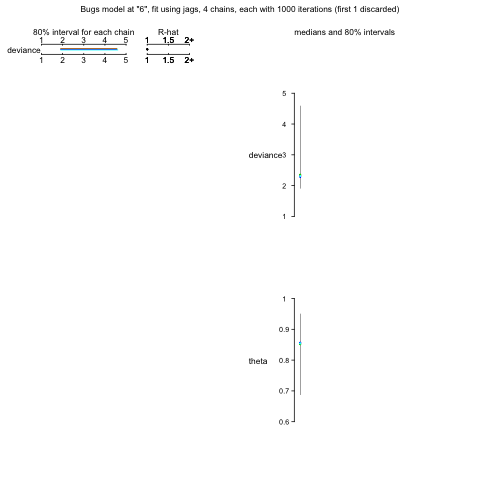

In [11]:
plot(fit)

We can alos visually inspect that samples, for each chain. The samples should look like a "fat, hairy caterpillar".

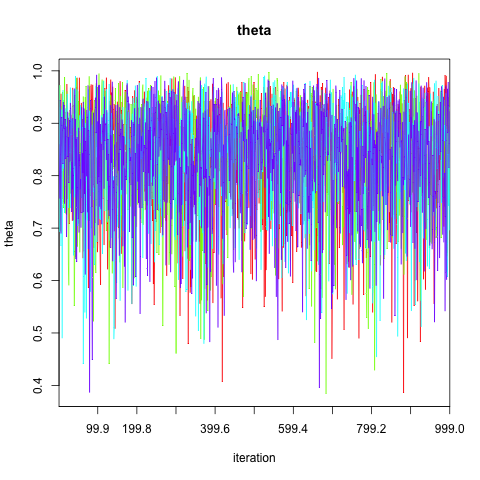

In [12]:
traceplot(fit, varname = "theta")

### Inspect the posterior samples

#### Visual inspection

We can use the package `mcmcplots` to visually inspect the samples:

In [14]:
library(mcmcplots)

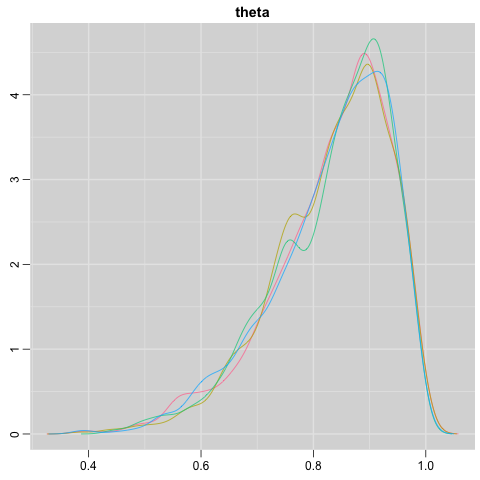

In [15]:
denplot(fit, parms = "theta")

#### Extract samples

We can also extract the samples for further processing. At the R command line, have a look at the object returned by the `jags()` function.

You can extract the samples, collapsed across all chains, from the list:

In [16]:
samples <- fit$BUGSoutput$sims.list
theta <- samples$theta

We can see that `theta` is vector of `1900` (why?) posterior samples of $\theta$.

In [16]:
dim(theta)

[1] 1900    1

We can now compute summary statistics for $\theta$:

In [17]:
mean(theta)

[1] 0.8343765

In [18]:
sd(theta)

[1] 0.103569

In [19]:
quantile(theta, c(0.025, 0.975))

     2.5%     97.5% 
0.5863363 0.9730511 

We can also plot `theta`:

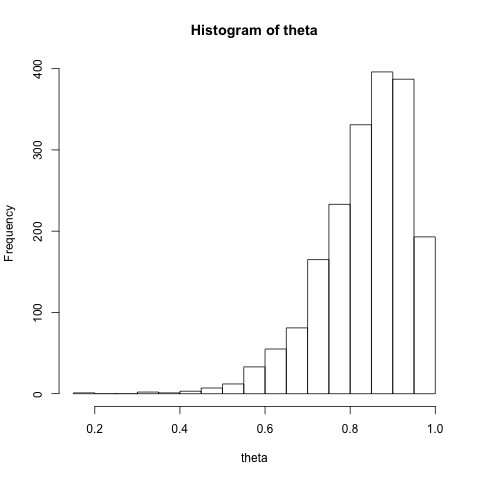

In [20]:
hist(theta)